# 3_Decision_Tree

In [28]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns

from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence
sns.set_style('whitegrid')

import matplotlib.font_manager as fm

### Import Data

In [4]:
P1K_merged = pd.read_csv('../Data/P1K_merged.csv', index_col=0)

In [6]:
df = P1K_merged.copy()

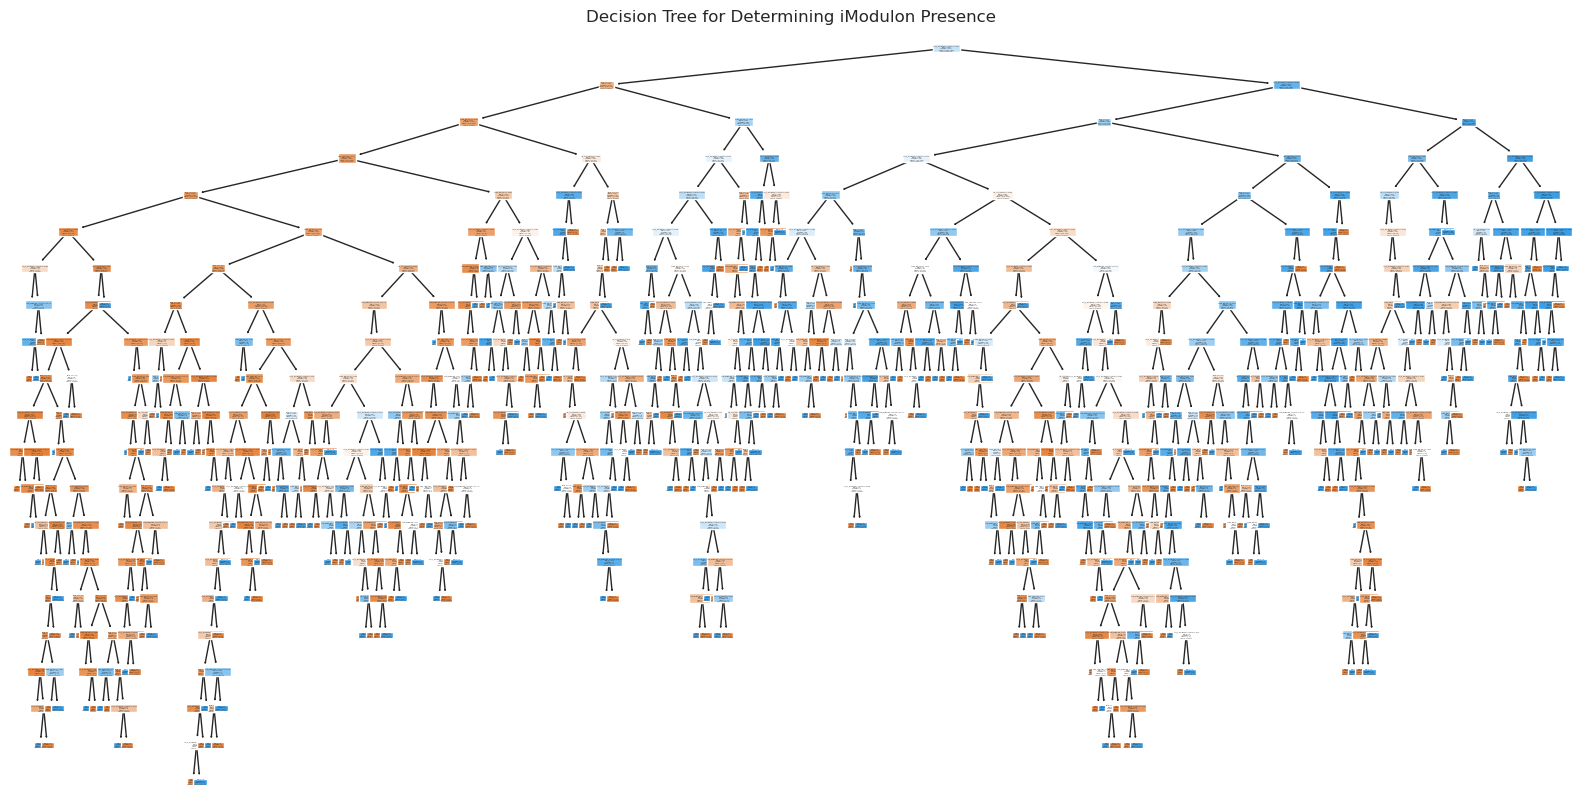

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Step 1: Transform the num_iM column to binary (0 = absence, 1 = presence)
df['num_iM_binary'] = df['num_iM'].apply(lambda x: 0 if x == 0 else 1)

# Step 2: Select the relevant features and the target column
features = ['Total_Explained_Variance', 'Top_1_Explained_Variance', 'Top_2_Explained_Variance', 'Top_3_Explained_Variance', 'num_regulators', 
            'MAD', 'log_TPM_median', 'range_log_tpm']
target = 'num_iM_binary'

X = df[features]
y = df[target]

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 5: Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=['Absence', 'Presence'], filled=True)
plt.title("Decision Tree for Determining iModulon Presence")
plt.show()


In [21]:
# Extract feature importance from the trained decision tree model
feature_importances = clf.feature_importances_

# Create a DataFrame to display feature importance alongside feature names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df


,Feature,Importance
0,Top_1_Explained_Variance,0.426379
1,MAD,0.150101
2,range_log_tpm,0.102725
3,log_TPM_median,0.096693
4,Total_Explained_Variance,0.070311
5,Top_3_Explained_Variance,0.066796
6,Top_2_Explained_Variance,0.057155
7,num_regulators,0.029840


In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Predict on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Recalculate the metrics as per the user's request
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report_dict = classification_report(y_test, y_pred, target_names=['Absence', 'Presence'], output_dict=True)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Extract the weighted average precision, recall, and F1-score from the classification report
precision = class_report_dict['weighted avg']['precision']
recall = class_report_dict['weighted avg']['recall']
f1_score = class_report_dict['weighted avg']['f1-score']

# Create a dataframe to store these values
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'Value': [accuracy, precision, recall, f1_score, roc_auc]
}

# Convert to DataFrame and set the 'Metric' as the index
metrics_df = pd.DataFrame(metrics_data).set_index('Metric')
metrics_df

,Value
Metric,
Accuracy,0.761737
Precision,0.762537
Recall,0.761737
F1-Score,0.762085
ROC AUC,0.755225


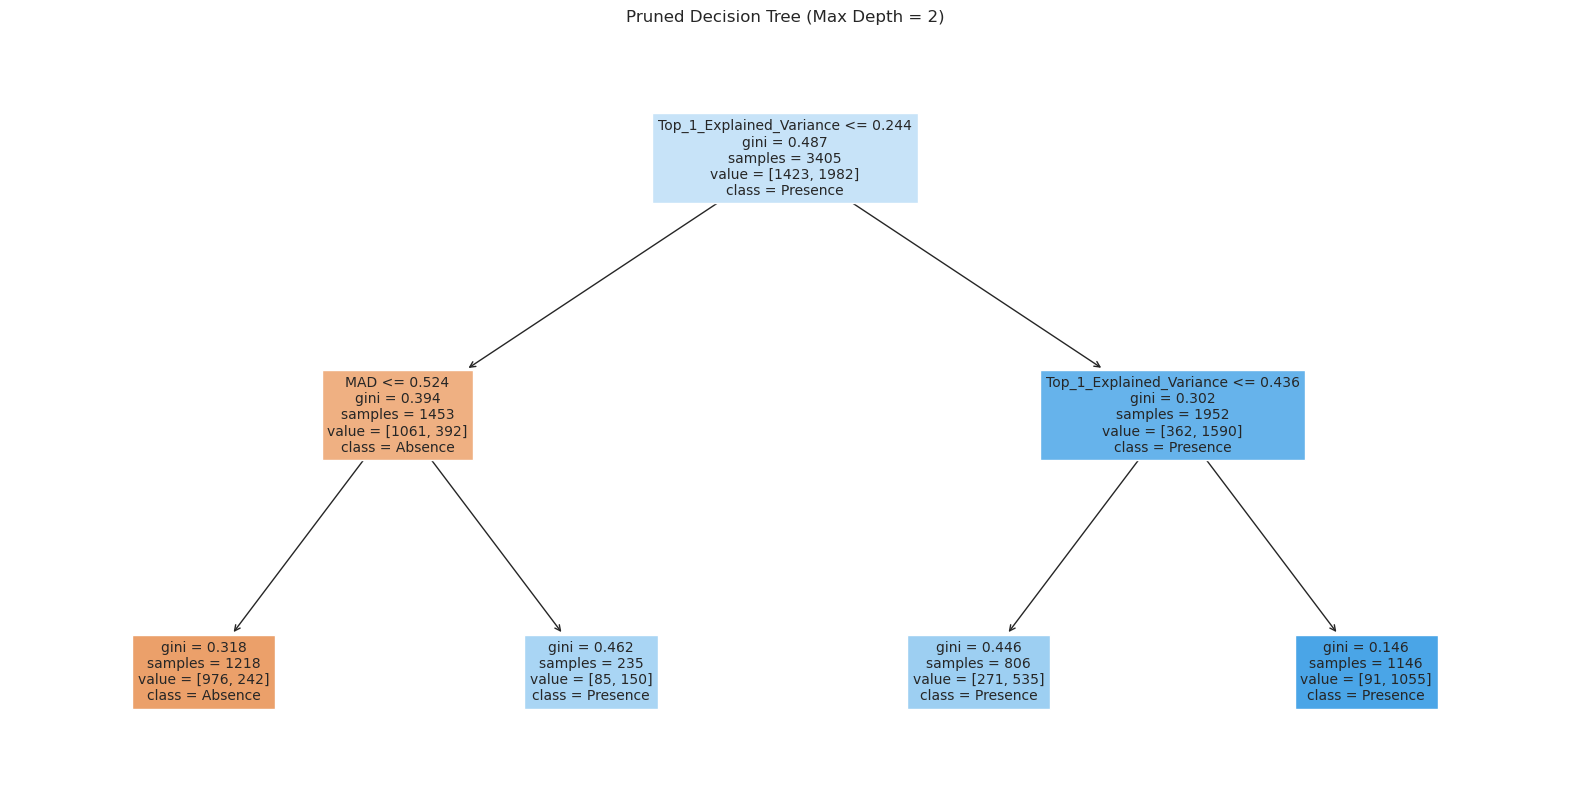

In [23]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train a pruned decision tree with a maximum depth to simplify the visualization
pruned_clf = DecisionTreeClassifier(random_state=42, max_depth=2)
pruned_clf.fit(X_train, y_train)

# Visualize the pruned tree with a smaller plot size
plt.figure(figsize=(20, 10))
plot_tree(pruned_clf, feature_names=features, class_names=['Absence', 'Presence'], filled=True, fontsize=10)
plt.title("Pruned Decision Tree (Max Depth = 2)")
plt.show()

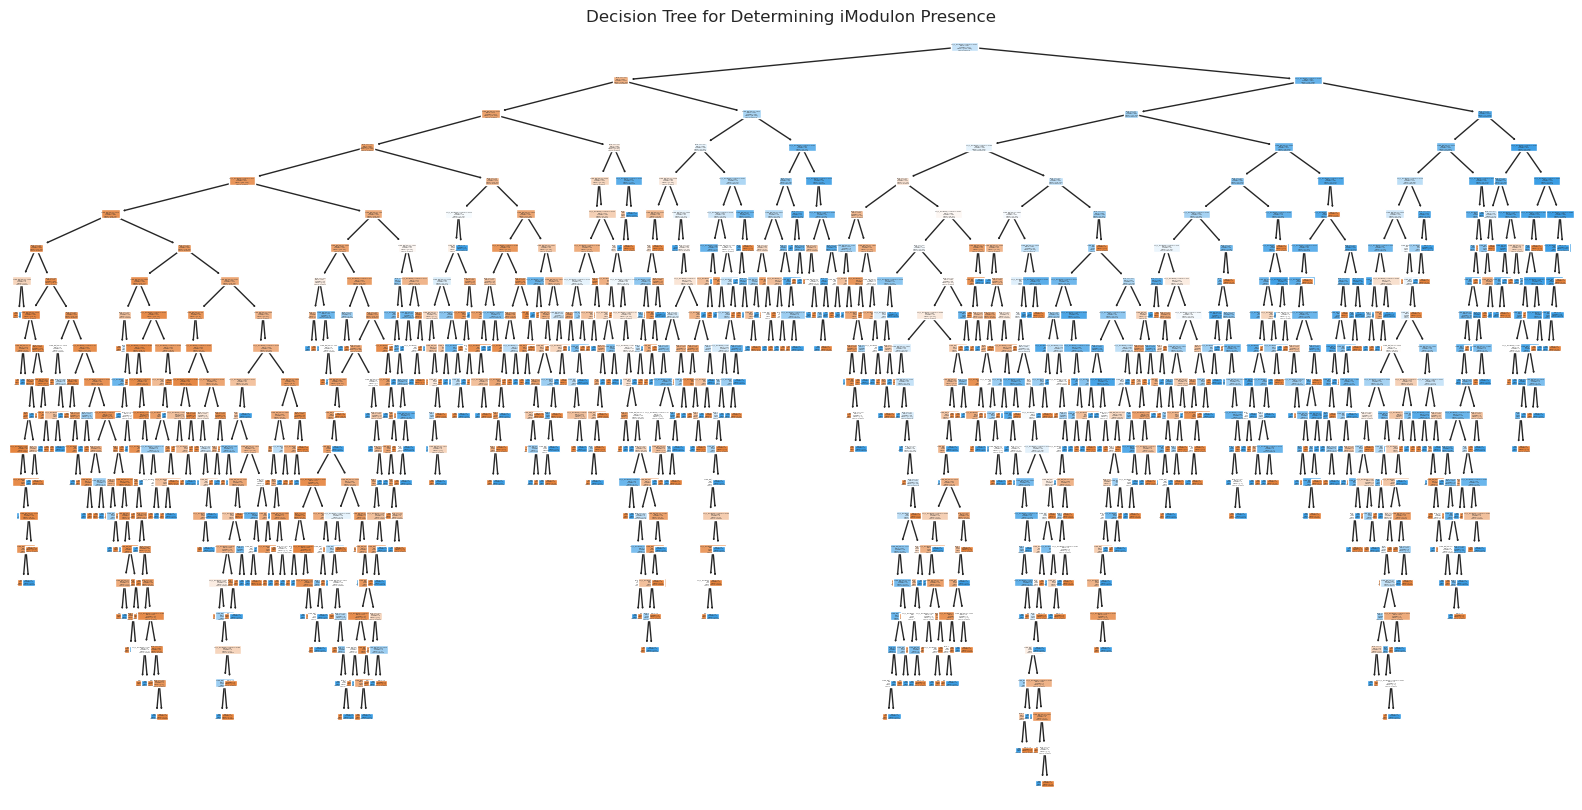

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Step 1: Transform the num_iM column to binary (0 = absence, 1 = presence)
df['num_iM_binary'] = df['num_iM'].apply(lambda x: 0 if x == 0 else 1)

# Step 2: Select the relevant features and the target column
features = ['Top_1_Explained_Variance', 
            'MAD', 'range_log_tpm']
target = 'num_iM_binary'

X = df[features]
y = df[target]

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 5: Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=['Absence', 'Presence'], filled=True)
plt.title("Decision Tree for Determining iModulon Presence")
plt.show()


In [25]:
# Extract feature importance from the trained decision tree model
feature_importances = clf.feature_importances_

# Create a DataFrame to display feature importance alongside feature names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df


,Feature,Importance
0,Top_1_Explained_Variance,0.525330
1,MAD,0.263317
2,range_log_tpm,0.211354


In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Predict on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Recalculate the metrics as per the user's request
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report_dict = classification_report(y_test, y_pred, target_names=['Absence', 'Presence'], output_dict=True)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Extract the weighted average precision, recall, and F1-score from the classification report
precision = class_report_dict['weighted avg']['precision']
recall = class_report_dict['weighted avg']['recall']
f1_score = class_report_dict['weighted avg']['f1-score']

# Create a dataframe to store these values
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'Value': [accuracy, precision, recall, f1_score, roc_auc]
}

# Convert to DataFrame and set the 'Metric' as the index
metrics_df = pd.DataFrame(metrics_data).set_index('Metric')
metrics_df

,Value
Metric,
Accuracy,0.746479
Precision,0.748902
Recall,0.746479
F1-Score,0.747356
ROC AUC,0.741864


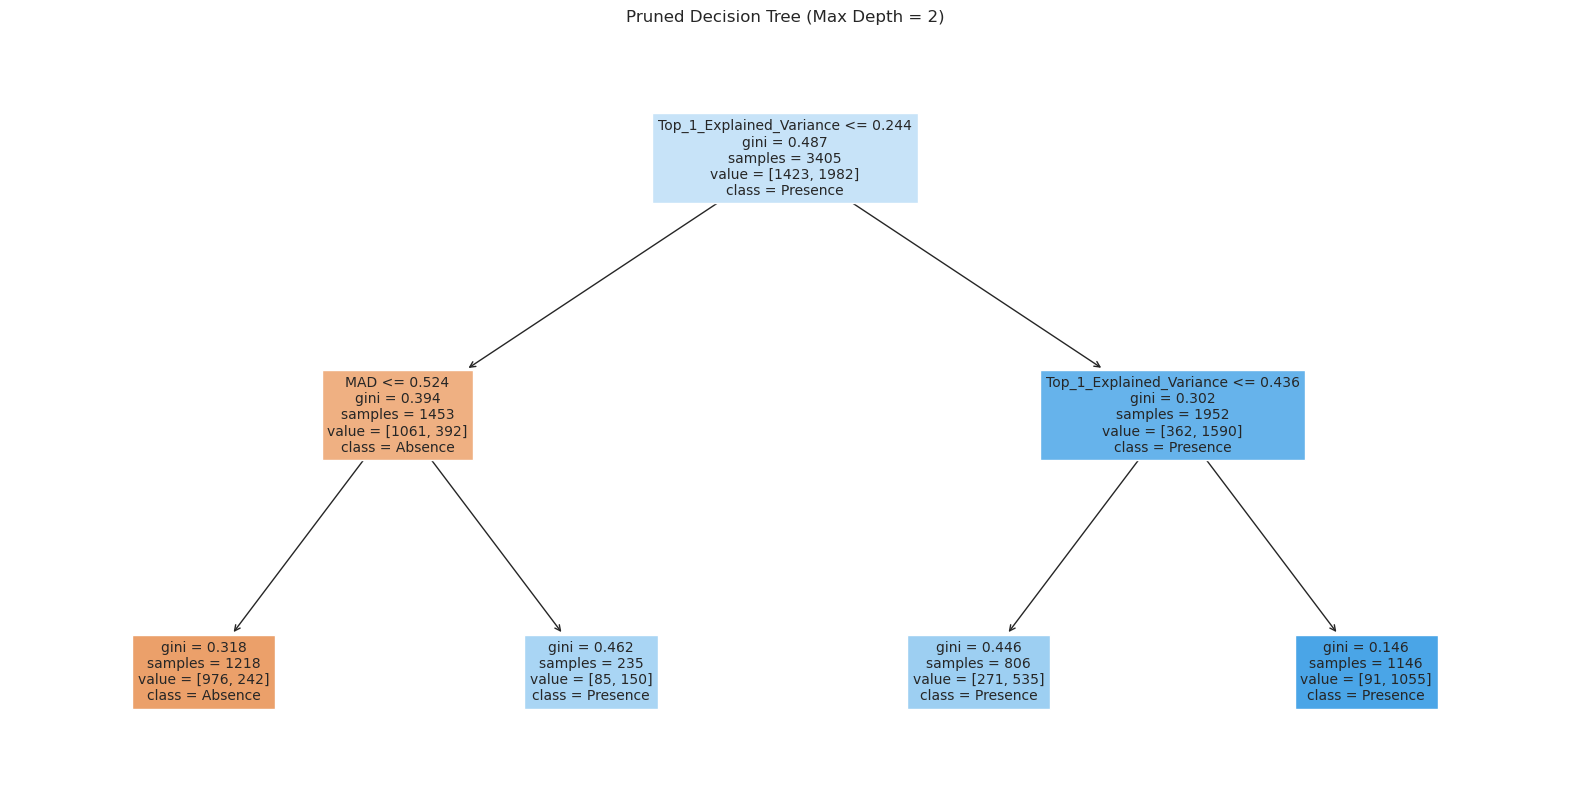

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train a pruned decision tree with a maximum depth to simplify the visualization
pruned_clf = DecisionTreeClassifier(random_state=42, max_depth=2)
pruned_clf.fit(X_train, y_train)

# Visualize the pruned tree with a smaller plot size
plt.figure(figsize=(20, 10))
plot_tree(pruned_clf, feature_names=features, class_names=['Absence', 'Presence'], filled=True, fontsize=10)
plt.title("Pruned Decision Tree (Max Depth = 2)")
plt.show()

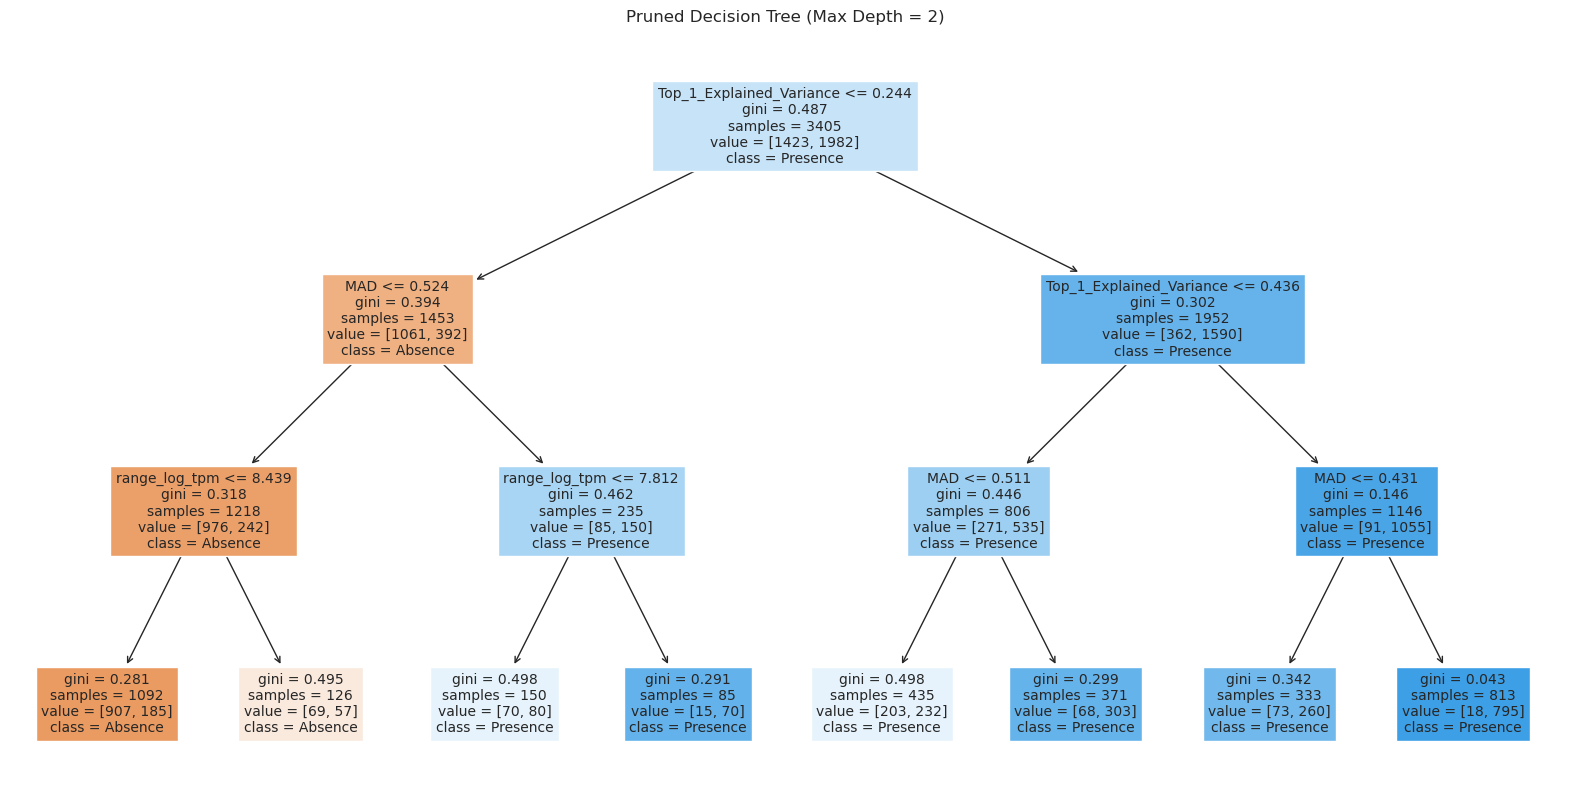

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train a pruned decision tree with a maximum depth to simplify the visualization
pruned_clf = DecisionTreeClassifier(random_state=42, max_depth=3)
pruned_clf.fit(X_train, y_train)

# Visualize the pruned tree with a smaller plot size
plt.figure(figsize=(20, 10))
plot_tree(pruned_clf, feature_names=features, class_names=['Absence', 'Presence'], filled=True, fontsize=10)
plt.title("Pruned Decision Tree (Max Depth = 2)")
plt.show()